In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
# HIDE OUTPUT
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 24.28 MiB/s, done.
Resolving deltas: 100% (98/98), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 5.1 MB/s eta 0:00:00


In [ ]:
!ls /content/stylegan3

avg_spectra.py	 dnnlib      environment.yml  gui_utils    metrics	training       viz
calc_metrics.py  Dockerfile  gen_images.py    legacy.py    README.md	train.py
dataset_tool.py  docs	     gen_video.py     LICENSE.txt  torch_utils	visualizer.py


In [1]:
# HIDE OUTPUT
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/"\
      "stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

!python /content/stylegan3/gen_images.py \
    --network={URL} \
  --outdir=/content/results --seeds=6600-6625


python3: can't open file '/content/stylegan3/gen_images.py': [Errno 2] No such file or directory


In [ ]:
!ls /content/results

seed6600.png  seed6604.png  seed6608.png  seed6612.png	seed6616.png  seed6620.png  seed6624.png
seed6601.png  seed6605.png  seed6609.png  seed6613.png	seed6617.png  seed6621.png  seed6625.png
seed6602.png  seed6606.png  seed6610.png  seed6614.png	seed6618.png  seed6622.png
seed6603.png  seed6607.png  seed6611.png  seed6615.png	seed6619.png  seed6623.png


In [ ]:
!cp /content/results/* \
    /content/drive/My\ Drive/projects/stylegan3

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8,
         nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs)
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const',
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [ ]:
#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/"\
#  "download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/"\
#  "download/v1/christmas-gan-2020-12-03.pkl"
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


Seed 1000
Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


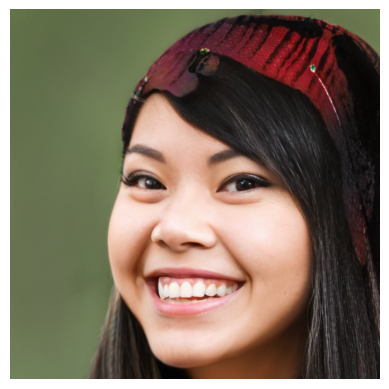

Seed 1001


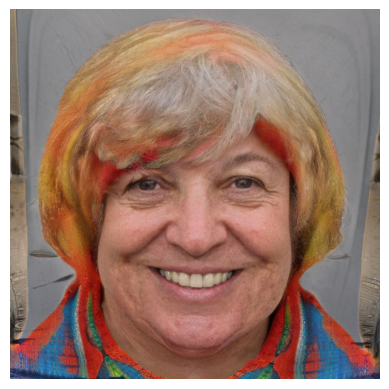

Seed 1002


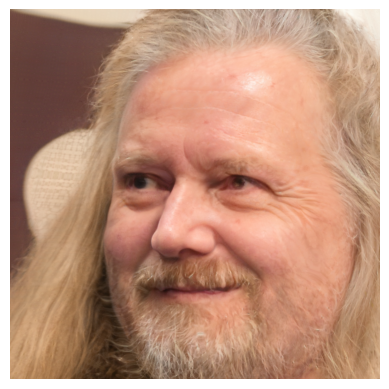

In [ ]:
# Choose your own starting and ending seed.
SEED_FROM = 1000
SEED_TO = 1003

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

In [ ]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) )
  return result

#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/"\
#  "download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/"\
#  "download/v1/christmas-gan-2020-12-03.pkl"
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim
# range(8192,8300)
seeds = expand_seed( [8192+1,8192+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
(1, 512)


In [ ]:
# HIDE OUTPUT
# Choose your seeds to morph through and the number of steps to
# take to get to each.

SEEDS = [6624,6618,6616] # Better for faces
#SEEDS = [1000,1003,1001] # Better for fish
STEPS = 100

# Remove any prior results
!rm /content/results/*

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1

# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

Seed 6624:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 6618:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


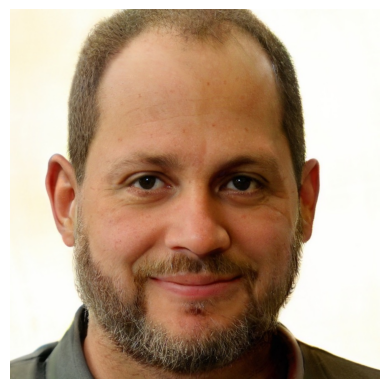

FAKE IMAGE


In [4]:
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from IPython.display import Video

# Mount Google Drive
drive.mount('/content/drive')

# Display Image
image_path = '/content/drive/My Drive/patt2/img.jpeg'
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()
print('FAKE IMAGE')



In [6]:
# Display Video
video_path = '/content/drive/My Drive/patt2/dhoni2.mp4'
Video(video_path)

In [8]:
from IPython.display import HTML

# Paths to the videos in Google Drive
video_path_1 = '/content/drive/My Drive/dhoni/dhoni.mp4'
video_path_2 = '/content/drive/My Drive/dhoni/dhoni1.mp4'

# HTML to display the videos side by side
html_code = f"""
<div style="display: flex; justify-content: space-around;">
  <div style="flex: 1; padding: 10px;">
    <video width="100%" controls>
      <source src="{video_path_1}" type="video/mp4">
    </video>
  </div>
  <div style="flex: 1; padding: 10px;">
    <video width="100%" controls>
      <source src="{video_path_2}" type="video/mp4">
    </video>
  </div>
</div>
"""

# Display the HTML
display(HTML(html_code))
